In [1]:
import json
import pandas as pd
import copy

aggregator_file = "./aggregate_scores_512.json"
scores = json.load(open(aggregator_file))

In [2]:
len(scores)

10

In [3]:
results = []

num_classes = 4

def is_same_experiment(e1, e2):
    return e1['is_normalized'] == e2['is_normalized'] and e1['loss_type'] == e2['loss_type']

def experiment_exists(exp):
    exists = False

    for r in results:
        if is_same_experiment(exp, r):
            exists = True

    return exists

# Each outer loop = each k
for k in range(len(scores)):
    for experiment in scores[k]:
        if not experiment_exists(experiment['experiment']):
            result_obj = copy.deepcopy(experiment['experiment'])
            result_obj['ave_macro_score'] = 0
            result_obj['model_file']

            for i in range(num_classes):
                result_obj['class_{}'.format(i)] = 0

            results.append(result_obj)

for result_obj_index in range(len(results)):
    for k in range(len(scores)):
        for exp_obj in scores[k]:
            result_obj = results[result_obj_index]
            if is_same_experiment(exp_obj['experiment'], result_obj):
                results[result_obj_index]['ave_macro_score'] += exp_obj['ave_macro_score']

                for label_index in range(num_classes):
                    ave_score = 0
                    for label_score_set in  exp_obj['label_scores']:
                        if label_index > len(label_score_set) - 1:
                            ave_score += 1
                        else:
                            ave_score += label_score_set[label_index]

                    ave_score /= len(exp_obj['label_scores'])
                    results[result_obj_index]['class_{}'.format(label_index)] += ave_score

# Average out
for result_obj in results:
    result_obj['ave_macro_score'] = result_obj['ave_macro_score'] / len(scores)

    for label_index in range(num_classes):
        result_obj['class_{}'.format(label_index)] /= len(scores)

results

[{'is_normalized': True,
  'loss_type': 'CE',
  'model_file': './models/covid19ctscan-512-512-CE-true.pth',
  'ave_macro_score': 0.294020763320448,
  'class_0': 0.8833574614321925,
  'class_1': 0.08225072629404971,
  'class_2': 0.05688698559202201,
  'class_3': 0.4619042016079131},
 {'is_normalized': False,
  'loss_type': 'CE',
  'model_file': './models/covid19ctscan-512-512-CE-false.pth',
  'ave_macro_score': 0.2895787746783447,
  'class_0': 0.8879607321260264,
  'class_1': 0.07722691160760456,
  'class_2': 0.049794814280601694,
  'class_3': 0.44000000000000006},
 {'is_normalized': True,
  'loss_type': 'DL',
  'model_file': './models/covid19ctscan-512-512-DL-true.pth',
  'ave_macro_score': 0.25570093628341195,
  'class_0': 0.876567536119849,
  'class_1': 0.08073440891351623,
  'class_2': 0.06080113912215808,
  'class_3': 0.004700660978124505},
 {'is_normalized': False,
  'loss_type': 'DL',
  'model_file': './models/covid19ctscan-512-512-DL-false.pth',
  'ave_macro_score': 0.2628947806

In [4]:
import pandas as pd

model_types = []

for result in results:
    model_types.append("{}-{}".format(result['loss_type'], result['is_normalized']))

df = pd.DataFrame(results, index=model_types)

df

,is_normalized,loss_type,model_file,ave_macro_score,class_0,class_1,class_2,class_3
CE-True,True,CE,./models/covid19ctscan-512-512-CE-true.pth,0.294021,0.883357,0.082251,0.056887,0.461904
CE-False,False,CE,./models/covid19ctscan-512-512-CE-false.pth,0.289579,0.887961,0.077227,0.049795,0.440000
DL-True,True,DL,./models/covid19ctscan-512-512-DL-true.pth,0.255701,0.876568,0.080734,0.060801,0.004701
DL-False,False,DL,./models/covid19ctscan-512-512-DL-false.pth,0.262895,0.882146,0.076020,0.062157,0.076148
TL-True,True,TL,./models/covid19ctscan-512-512-TL-true.pth,0.258371,0.876497,0.077955,0.059916,0.040153
TL-False,False,TL,./models/covid19ctscan-512-512-TL-false.pth,0.260481,0.882890,0.076646,0.060111,0.054168


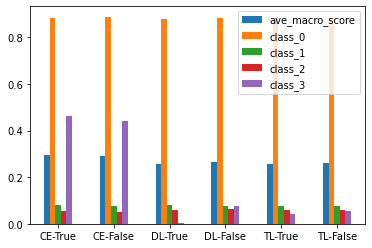

In [5]:
ax = df.plot.bar(rot=0)

In [6]:
best_models = []

metrics = [
    'ave_macro_score',
    'class_0',
    'class_1',
    'class_2',
    'class_3'
]

for metric in metrics:
    best_score = 0.001
    best_model = ''
    improvement_raw = 0.0
    for result in results:
        if result[metric] > best_score:
            improvement_raw = result[metric] - best_score
            best_score = result[metric]
            best_model = "{}-{}".format(result['loss_type'], result['is_normalized'])

    best_models.append({'metric': metric, 'best_model': best_model, 'improvement_raw': improvement_raw, 'model_file': result['model_file'] })

df_best_models = pd.DataFrame(best_models)

df_best_models

,metric,best_model,improvement_raw,model_file
0,ave_macro_score,CE-True,0.293021,./models/covid19ctscan-512-512-TL-false.pth
1,class_0,CE-False,0.004603,./models/covid19ctscan-512-512-TL-false.pth
2,class_1,CE-True,0.081251,./models/covid19ctscan-512-512-TL-false.pth
3,class_2,DL-False,0.001356,./models/covid19ctscan-512-512-TL-false.pth
4,class_3,CE-True,0.460904,./models/covid19ctscan-512-512-TL-false.pth


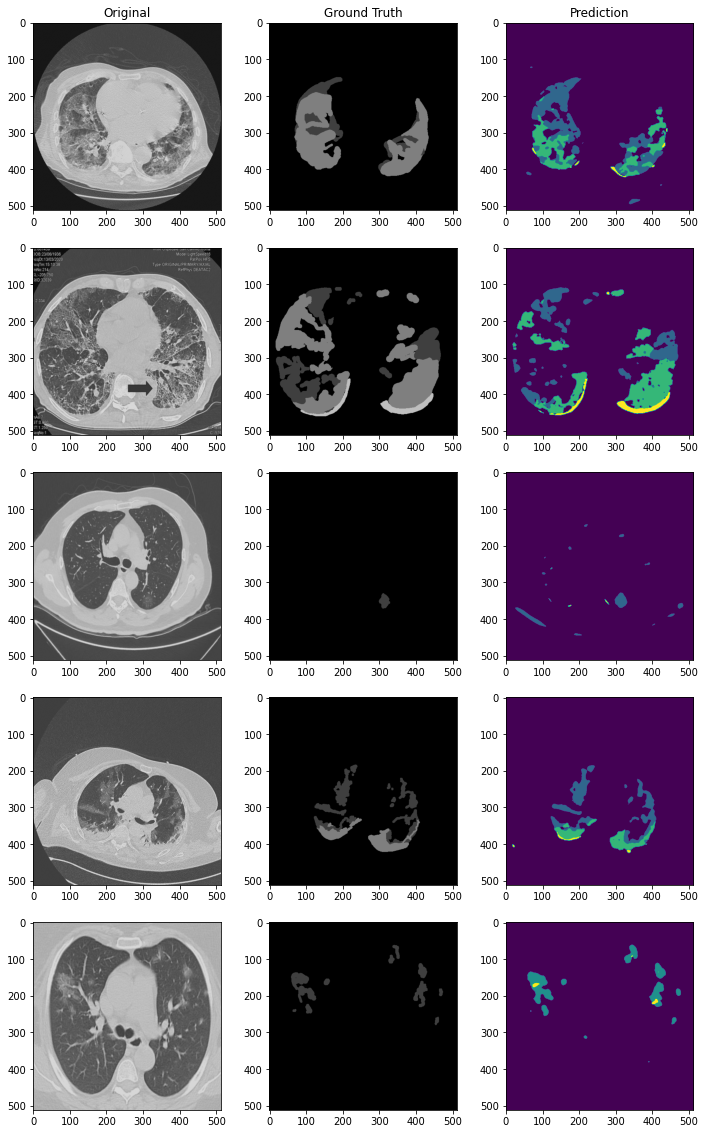

In [7]:
import glob
import cv2
import matplotlib.pyplot as plt
import sys
import os
import numpy as np
sys.path.append(os.path.join('./','../pyunet'))
from lib.unet import UNet
import torch

def get_image(file):
    img = cv2.resize(
        cv2.imread(
            file
        ),
        dim
    ) / 255

    return img

def get_mask(file):
    img = cv2.resize(
        cv2.imread(
            file
        ),
        dim
    ) / num_classes

    return img

def get_predicted_image(img, model_file, device='cpu'):
    state = torch.load(model_file, map_location=device)
    model = UNet(
        in_channels=3,
        out_channels=4,
        is_normalized=False
    ).to(device)

    model.load_state_dict(state['state_dict'])

    input_img = img.transpose((2, 0, 1))

    x = torch.Tensor(np.array([input_img])).to(device)

    result = model.forward(x)
    result = torch.argmax(result, 1).detach().cpu().numpy().astype(np.float32)
    result = result.transpose((1, 2, 0)) / state['out_channels']

    return result

images = sorted(glob.glob('./images/covid19ctscan/images/*'))
masks = sorted(glob.glob('./images/covid19ctscan/masks/*'))

img_width = 512
img_height = 512

dim = (img_width, img_height)

#num_images = len(images)
num_images = 5
num_cols = 3

col_names = [
    "Original",
    "Ground Truth",
    "Prediction"
]

fig, axes = plt.subplots(nrows=num_images, ncols=num_cols, figsize=(num_cols*4, num_images*4))

for ax, col in zip(axes[0], col_names):
    ax.set_title(col)

counter = 0
for i in range(num_images):
    image_file = images[i]
    mask_file = masks[i]
    img = get_image(image_file)
    mask = get_mask(mask_file)
    prediction = get_predicted_image(img, df_best_models.values[0][3])
    
    counter += 1
    
    plt.subplot(num_images, num_cols, counter)
    plt.imshow(img)
    
    counter += 1
    
    plt.subplot(num_images, num_cols, counter)
    plt.imshow(mask)
    
    counter += 1
    
    plt.subplot(num_images, num_cols, counter)
    plt.imshow(prediction)

plt.show()